# Name: Ahmed Mohamed Fekry Bagha
# ID: 4211032
# Group: (A) & Section: (B1)
# CNN - LSTM Assignment For "Solving Human Activity Recognition (HAR)"

### Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

warnings.filterwarnings("ignore")

### Read and Clean Data

In [2]:
dataFile = 'assignmentDataSet.txt'

df = pd.read_csv(dataFile, header=None, names=['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z'], on_bad_lines='skip')  

df['Z'] = df['Z'].astype(str).str.replace(';', '').astype(float)

df

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1086461,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1086462,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1086463,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1086464,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


### Data Visualization

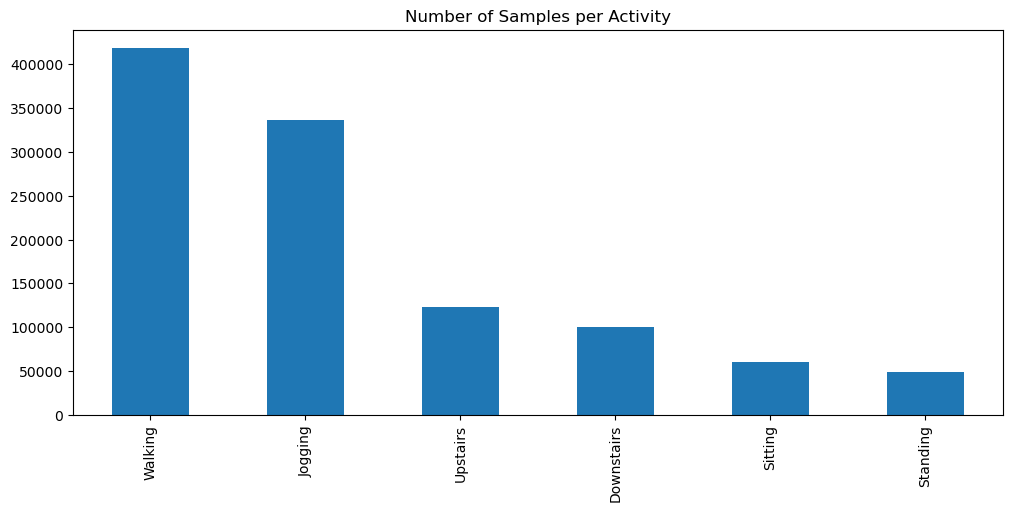

In [3]:
plt.figure(figsize=(12, 5))
df['activity'].value_counts().plot(kind='bar', title='Number of Samples per Activity')
plt.show()

### Handle Missing Values

In [4]:
label_encoder = LabelEncoder()
df['activityEncode'] = label_encoder.fit_transform(df['activity'])
df['Z'].fillna(df['Z'].mean(), inplace=True)

### Split Data into Training and Testing Sets

In [5]:
df_train = df[df['user-id'] <= 27]
df_test = df[df['user-id'] > 27]

### Normalize Data

In [6]:
for col in ['X', 'Y', 'Z']:
    df_train[col] = (df_train[col] - df_train[col].min()) / (df_train[col].max() - df_train[col].min())
    df_test[col] = (df_test[col] - df_test[col].min()) / (df_test[col].max() - df_test[col].min())

### Data Segmentation

In [7]:
def segment_data(df, time_steps, step, label_name):
    segments, labels = [], []
    for i in range(0, len(df) - time_steps, step):
        xs, ys, zs = df['X'].values[i:i+time_steps], df['Y'].values[i:i+time_steps], df['Z'].values[i:i+time_steps]
        label = mode(df[label_name][i:i+time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)
    return np.array(segments, dtype=np.float32).reshape(-1, time_steps, 3), np.array(labels)

TIME_STEPS, STEP_SIZE, LABEL_COL = 80, 40, 'activityEncode'
x_train, y_train = segment_data(df_train, TIME_STEPS, STEP_SIZE, LABEL_COL)

### Model Architecture(CNN + LSTM)

In [8]:
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(TIME_STEPS, 3), activation='relu'),
    LSTM(32, return_sequences=True, activation='relu'),
    Conv1D(64, kernel_size=2, activation='relu', strides=2),
    MaxPool1D(pool_size=4, padding='same'),
    Conv1D(192, kernel_size=2, activation='relu', strides=1),
    GlobalAveragePooling1D(),
    BatchNormalization(epsilon=1e-06),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Model Training

In [9]:
y_train_hot = to_categorical(y_train, num_classes=len(label_encoder.classes_))
history = model.fit(x_train, y_train_hot, batch_size=128, epochs=25)

Epoch 1/25
157/157 [==============================] - 13s 60ms/step - loss: 0.7679 - accuracy: 0.7318
Epoch 2/25
157/157 [==============================] - 10s 62ms/step - loss: 0.5365 - accuracy: 0.8047
Epoch 3/25
157/157 [==============================] - 9s 60ms/step - loss: 0.4672 - accuracy: 0.8271
Epoch 4/25
157/157 [==============================] - 9s 60ms/step - loss: 0.4226 - accuracy: 0.8422
Epoch 5/25
157/157 [==============================] - 9s 59ms/step - loss: 0.3956 - accuracy: 0.8534
Epoch 6/25
157/157 [==============================] - 9s 60ms/step - loss: 0.3732 - accuracy: 0.8613
Epoch 7/25
157/157 [==============================] - 9s 60ms/step - loss: 0.3717 - accuracy: 0.8633
Epoch 8/25
157/157 [==============================] - 9s 60ms/step - loss: 0.3442 - accuracy: 0.8714
Epoch 9/25
157/157 [==============================] - 9s 60ms/step - loss: 0.3250 - accuracy: 0.8813
Epoch 10/25
157/157 [==============================] - 11s 68ms/step - loss: 0.3166 - acc

### Model Evaluation

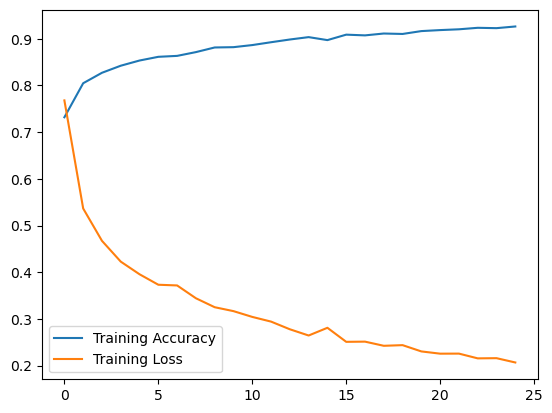

In [10]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.legend()
plt.show()

### Testing

In [11]:
x_test, y_test = segment_data(df_test, TIME_STEPS, STEP_SIZE, LABEL_COL)
y_test_hot = to_categorical(y_test, num_classes=len(label_encoder.classes_))
score = model.evaluate(x_test, y_test_hot)
print(f"Accuracy: {score[1]:.4f}, Loss: {score[0]:.4f}")

223/223 [==============================] - 4s 15ms/step - loss: 0.9122 - accuracy: 0.7579
Accuracy: 0.7579, Loss: 0.9122


### Confusion Matrix

223/223 [==============================] - 3s 12ms/step


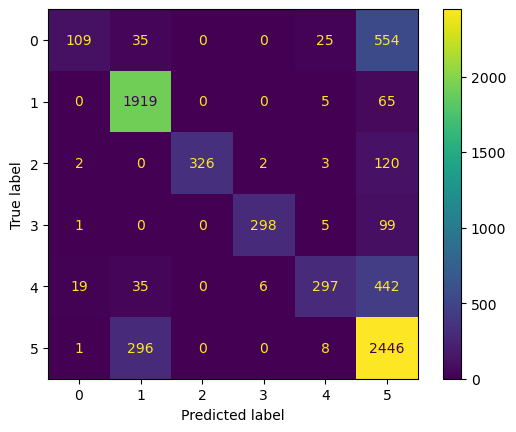

              precision    recall  f1-score   support

           0       0.83      0.15      0.25       723
           1       0.84      0.96      0.90      1989
           2       1.00      0.72      0.84       453
           3       0.97      0.74      0.84       403
           4       0.87      0.37      0.52       799
           5       0.66      0.89      0.76      2751

    accuracy                           0.76      7118
   macro avg       0.86      0.64      0.68      7118
weighted avg       0.79      0.76      0.73      7118



In [12]:
y_pred = model.predict(x_test)
predictions = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test_hot, axis=1)
cm = confusion_matrix(y_test_labels, predictions)
ConfusionMatrixDisplay(cm).plot()
plt.show()
print(classification_report(y_test_labels, predictions))